<font size = 6> Credit Card Customer Churn (unsupervised)<font> <br>

<font size = 5> **About Data** <font>

In this project we will be classifying credit card customer data for churn behavior using Kmeans Clustering on the data below:


A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

Here is the link to the dataset in Kaggle:

https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

Now, this dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

<font size = 5> **Load Packages** <font>

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler

<font size = 5> **Read Data** <font>

In [105]:
df = pd.read_csv("BankChurners.csv")

#data size
print(df.shape)

df.head()

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [106]:
#feature types
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

first column is client id and two last columns are for naive bayes model so we can eliminate them.

In [107]:
#remove 1st, and two last columns
df.drop(df.columns[[0, 21, 22]], axis = 1, inplace = True)

In [108]:
df.select_dtypes(["object"])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue
3,Existing Customer,F,High School,Unknown,Less than $40K,Blue
4,Existing Customer,M,Uneducated,Married,$60K - $80K,Blue
...,...,...,...,...,...,...
10122,Existing Customer,M,Graduate,Single,$40K - $60K,Blue
10123,Attrited Customer,M,Unknown,Divorced,$40K - $60K,Blue
10124,Attrited Customer,F,High School,Married,Less than $40K,Blue
10125,Attrited Customer,M,Graduate,Unknown,$40K - $60K,Blue


In [109]:
#define a function to show the unique values of a column
def unique_values(df):
    dict = {}
    categorical_cols = df.select_dtypes(["object"]).columns
    for col in categorical_cols:
        dict[col] = df[col].unique()
    return dict


unique_values(df)

{'Attrition_Flag': array(['Existing Customer', 'Attrited Customer'], dtype=object),
 'Gender': array(['M', 'F'], dtype=object),
 'Education_Level': array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
        'Post-Graduate', 'Doctorate'], dtype=object),
 'Marital_Status': array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object),
 'Income_Category': array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
        '$120K +', 'Unknown'], dtype=object),
 'Card_Category': array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)}

**Note:** <br>
We see that there are some unknown categories for columns Education_Level, Martial_Status and Income_Category. Let's check them out.

In [110]:
print(df[df["Income_Category"] == "Unknown"].shape[0])
print(df[df["Marital_Status"] == "Unknown"].shape[0])
print(df[df["Education_Level"] == "Unknown"].shape[0])

1112
749
1519


In [111]:
#define a function to replace unknown values with the majority category of each column
def missing_value_filler(column):
    majority_category = column.mode()[0]
    column = column.replace("Unknown", majority_category)
    return column

#Apply function on the columns with missing values
missing_columns = ["Income_Category", "Marital_Status", "Education_Level"]
df[missing_columns] = df[missing_columns].apply(missing_value_filler, axis = 0)

#change name of target column 
df.rename(columns = {"Attrition_Flag": "churn"}, inplace = True)
df["churn"] = df["churn"].map({'Existing Customer': 0, 'Attrited Customer': 1})

<font size = 5> **Any null values?** <font>

In [112]:
df.isnull().sum()

churn                       0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

<font size = 5> **Data Visualization** <font>

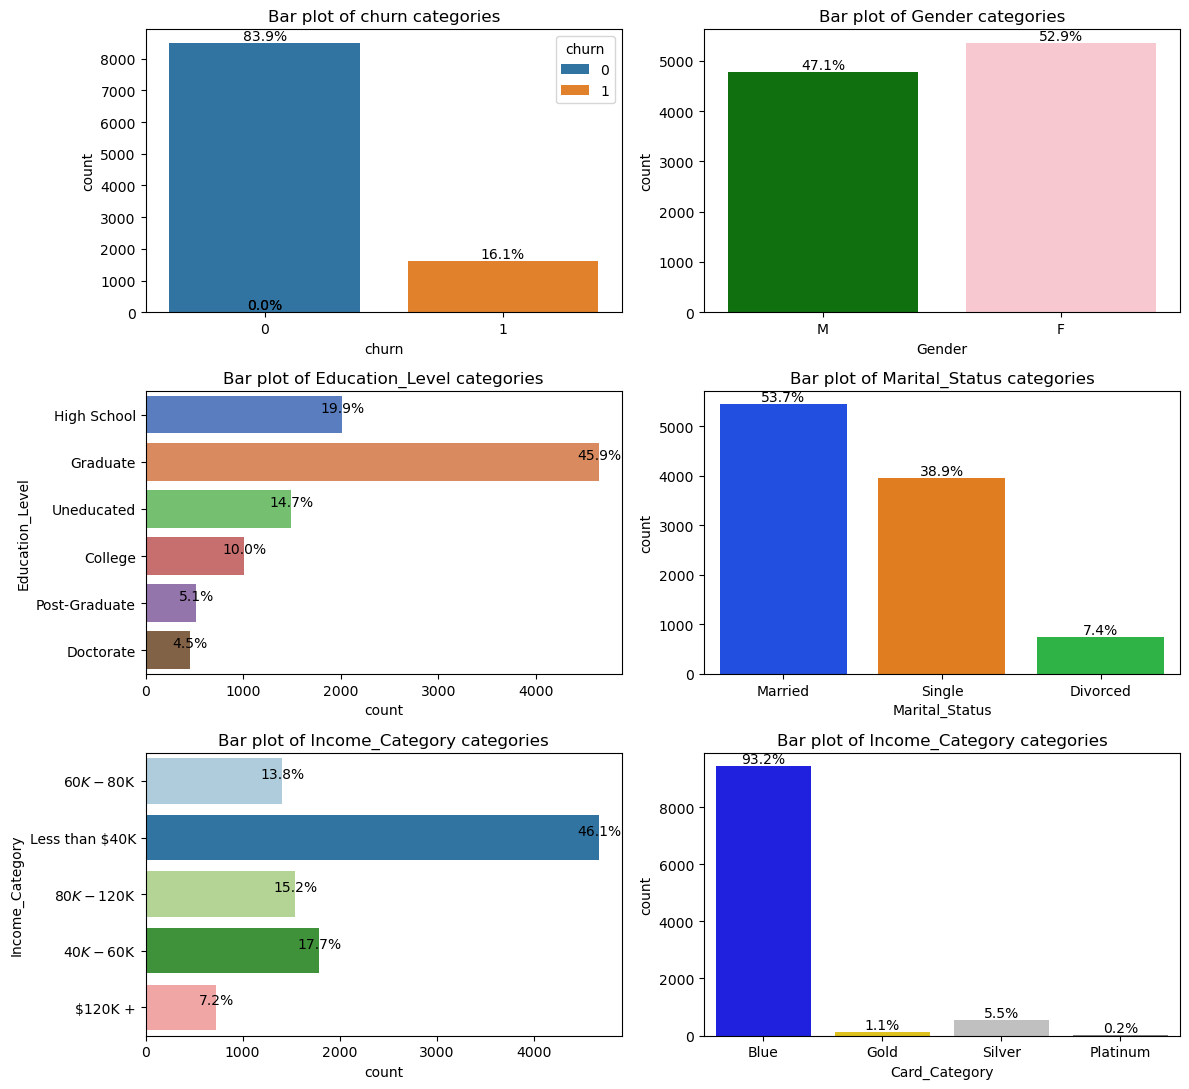

In [113]:
fig, axes = plt.subplots(3, 2, figsize = (12, 11))


##Attrition_Flag Plot
sns.countplot(x = "churn", data = df, 
              hue = "churn",
              ax = axes[0, 0])
axes[0, 0].set_title("Bar plot of churn categories")

counts = df['churn'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 0].text(x, y, percentage, ha='center', va='bottom')


##Gender Plot
sns.countplot(x = "Gender", data = df,
              hue = "Gender", palette = ["green", "pink"],
              ax = axes[0, 1])
axes[0, 1].set_title("Bar plot of Gender categories")


counts = df['Gender'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 1].text(x, y, percentage, ha='center', va='bottom')


##Education_Level Plot
sns.countplot(y = "Education_Level", data = df,
              hue = "Education_Level", palette = "muted",
              ax = axes[1, 0])
axes[1, 0].set_title("Bar plot of Education_Level categories")
\
counts = df['Education_Level'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[1, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = width
    y = p.get_y() + height / 2
    percentage = f'{width / total * 100:.1f}%'
    axes[1, 0].text(x + 5, y, percentage, ha='center', va='bottom')


##Marital_Status Plot
sns.countplot(x = "Marital_Status", data = df,
              hue = "Marital_Status", palette = "bright",
              ax = axes[1, 1])
axes[1, 1].set_title("Bar plot of Marital_Status categories")

counts = df['Marital_Status'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[1, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[1, 1].text(x , y, percentage, ha='center', va='bottom')

##Income_Category Plot
sns.countplot(y = "Income_Category", data = df,
              hue = "Income_Category", palette = "Paired",
              ax = axes[2, 0])
axes[2, 0].set_title("Bar plot of Income_Category categories")

counts = df['Income_Category'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[2, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = width
    y = p.get_y() + height / 2
    percentage = f'{width / total * 100:.1f}%'
    axes[2, 0].text(x + 5 , y, percentage, ha='center', va='bottom')



##Card_Category Plot
sns.countplot(x = "Card_Category", data = df,
              hue = "Card_Category", palette = ["blue", "gold", "silver", "grey"],
              ax = axes[2, 1])
axes[2, 1].set_title("Bar plot of Income_Category categories")

counts = df['Income_Category'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[2, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[2, 1].text(x , y, percentage, ha='center', va='bottom')

plt.tight_layout()


**Note:** <br>
Observations based on the plots: <br>
The credit card customers are mostly graduates, existing customer, married, with less than 40K$ annual salary and blue card holders. <br>
The target variable (churn) is imbalanced, with only 16% of cases resulting in churn.

Text(0.5, 1.0, 'Box plot of Credit_Limit based on Gender')

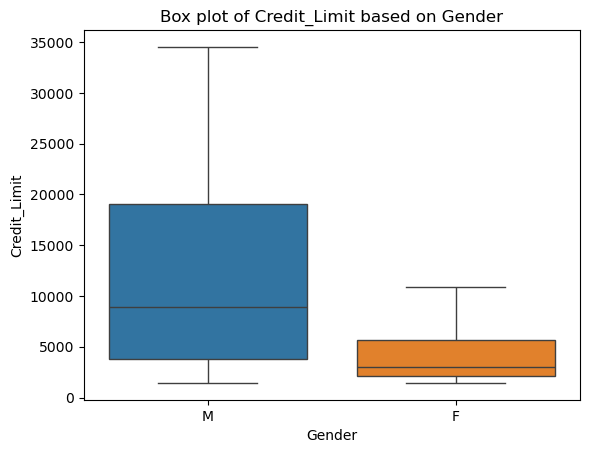

In [114]:
sns.boxplot(x = "Gender", y = "Credit_Limit",data = df,
           hue = "Gender", showfliers = False)
plt.title("Box plot of Credit_Limit based on Gender")

**Note:** <br>
Although the number of female credit card holders is higher, their average credit limit, as well as their 1st and 3rd quartile limits, are lower compared to males.

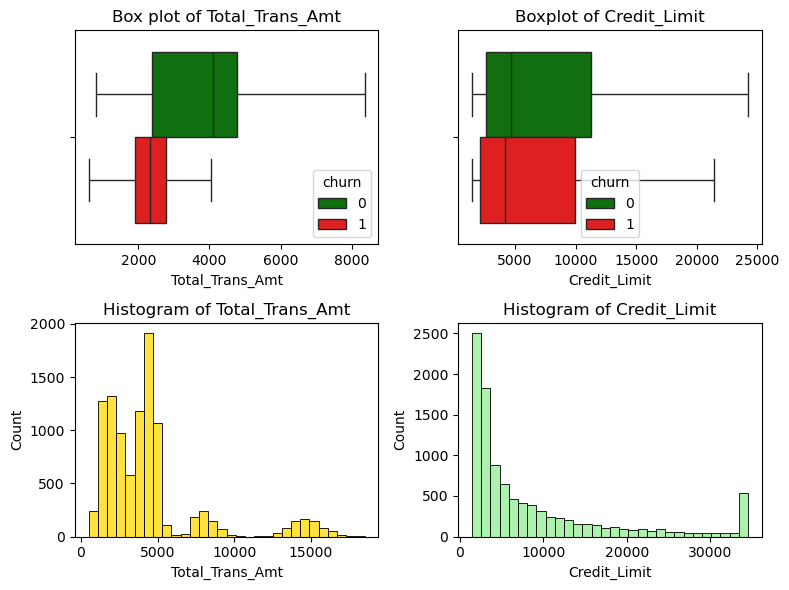

In [115]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

#distribution of Total_Trans_Amt
sns.boxplot(x = "Total_Trans_Amt", data = df, 
            hue = "churn", palette = ["green", "red"],
            showfliers = False,
            ax = axes[0, 0])
axes[0, 0].set_title("Box plot of Total_Trans_Amt")

sns.histplot(df["Total_Trans_Amt"], 
             bins = 30, color = "gold",
             ax = axes[1, 0])
axes[1, 0].set_title("Histogram of Total_Trans_Amt")

#distribution of
sns.boxplot(x = "Credit_Limit", data = df,
            hue = "churn", palette = ["green", "red"], 
            showfliers = False, 
            ax = axes[0, 1])
axes[0, 1].set_title("Boxplot of Credit_Limit")

sns.histplot(x = df["Credit_Limit"],
             bins = 30, color = "lightgreen",
             ax = axes[1, 1])
axes[1, 1].set_title("Histogram of Credit_Limit")
plt.tight_layout()

The total transaction amount has a multimodal distribution, which can help us identify different customer clusters. On the other hand, the credit limit is right-skewed and has a sudden spike at the high end, which is pretty interesting. Churn and non-churn creditcard holders have distinct distribution of Total_Trans_Amt, however their Credit_Limit transaction look similar.

Text(0.5, 1.0, 'Box plot of Avg_Utilization_Ratio')

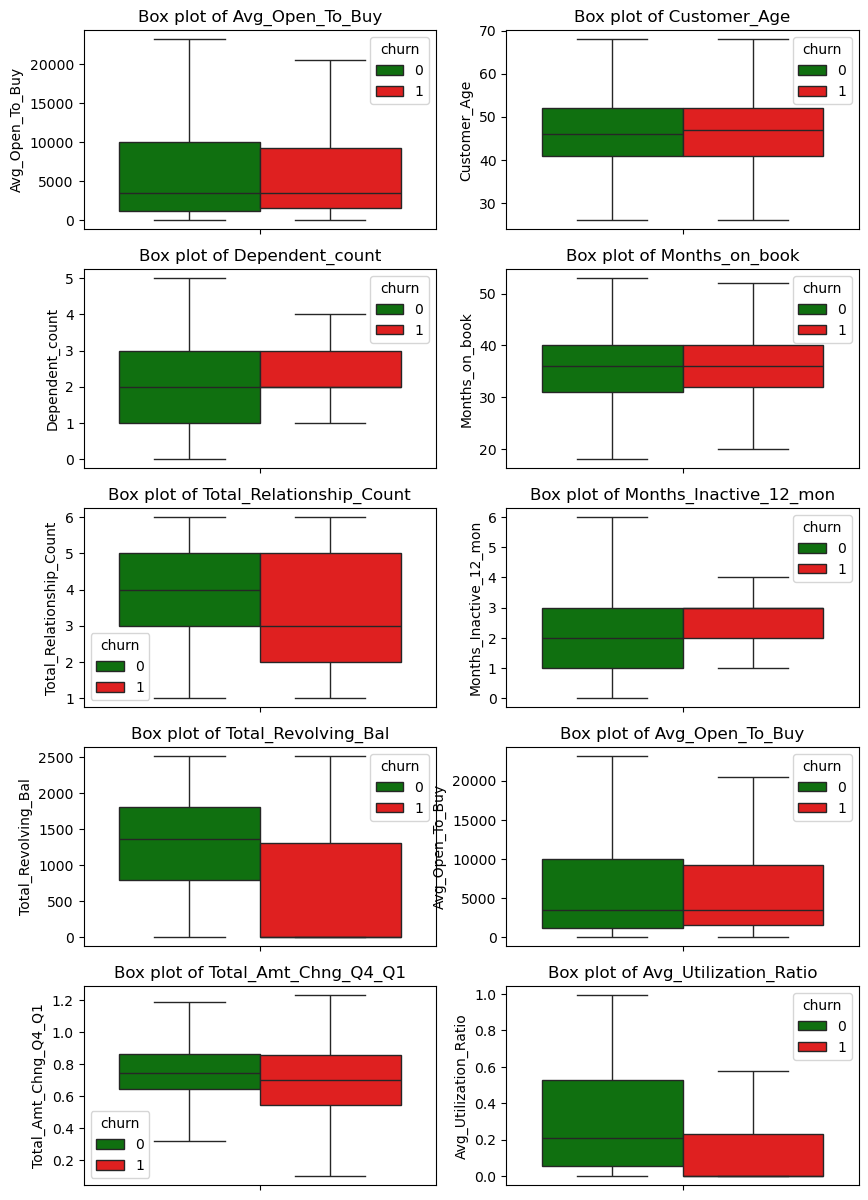

In [116]:
fig, axes = plt.subplots(5, 2, figsize = (10, 15))

#Avg_Open_To_Buy
sns.boxplot(y = "Avg_Open_To_Buy", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[0, 0])
axes[0, 0].set_title("Box plot of Avg_Open_To_Buy")


#Customer_Age
sns.boxplot(y = "Customer_Age", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[0, 1])
axes[0, 1].set_title("Box plot of Customer_Age")


#Dependent_count
sns.boxplot(y = "Dependent_count", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[1, 0])
axes[1, 0].set_title("Box plot of Dependent_count")


#Months_on_book
sns.boxplot(y = "Months_on_book", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[1, 1])
axes[1, 1].set_title("Box plot of Months_on_book")


#Total_Relationship_Count
sns.boxplot(y = "Total_Relationship_Count", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[2, 0])
axes[2, 0].set_title("Box plot of Total_Relationship_Count")


#Months_Inactive_12_mon
sns.boxplot(y = "Months_Inactive_12_mon", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[2, 1])
axes[2, 1].set_title("Box plot of Months_Inactive_12_mon")


#Total_Revolving_Bal
sns.boxplot(y = "Total_Revolving_Bal", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[3, 0])
axes[3, 0].set_title("Box plot of Total_Revolving_Bal")


#Avg_Open_To_Buy
sns.boxplot(y = "Avg_Open_To_Buy", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[3, 1])
axes[3, 1].set_title("Box plot of Avg_Open_To_Buy")


#Total_Amt_Chng_Q4_Q1
sns.boxplot(y = "Total_Amt_Chng_Q4_Q1", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[4, 0])
axes[4, 0].set_title("Box plot of Total_Amt_Chng_Q4_Q1")


#Avg_Utilization_Ratio
sns.boxplot(y = "Avg_Utilization_Ratio", data = df,
            hue = "churn", showfliers = False, palette = ["green", "red"], 
            ax = axes[4, 1])
axes[4, 1].set_title("Box plot of Avg_Utilization_Ratio")

**Note:** <br>
Based on the box plots above, Avg_Utilization_Ratio, Total_Revolving_Bal and Total_Trans_Amt have the most distinct distributions based on the churn status, so these could be good predictors of the churn behavior pattern. Before eliminating any features, let's get help from random forest model for feature selection.

<font size = 5> Convert categorical volumns to dummy variables <font>

In [117]:
categorical_columns = df.select_dtypes("object").columns.tolist()
df_dummies = pd.get_dummies(df, columns=categorical_columns, 
                            drop_first = True, dtype = "int")

<font size = 5> **Split Train and Test sets:** <font>

In [118]:
X = df_dummies.drop("churn", axis = 1)
Y = df_dummies["churn"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 22)

<font size = 5> **Random Forest Model:** <font>

In [119]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

#fit the model
rf_model.fit(X_train, Y_train)

# Make predictions
Y_pred = rf_model.predict(X_test)

In [120]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)
matrix = confusion_matrix(Y_test, Y_pred)

print("Accuracy is ", round(accuracy, 3))
print("Classification Report: \n", report)

Accuracy is  0.953
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2528
           1       0.91      0.80      0.85       511

    accuracy                           0.95      3039
   macro avg       0.94      0.89      0.91      3039
weighted avg       0.95      0.95      0.95      3039



Text(0.5, 1.0, 'Confusion Matrix')

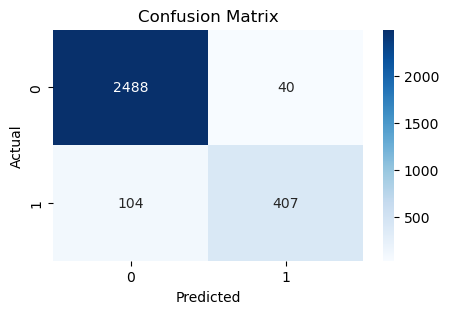

In [121]:
plt.figure(figsize = (5, 3))
sns.heatmap(matrix, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

We see that since the data was imbalanced, the minority class(churn) was misclassified more than the majority class

<font size = 5> Feature Importance <font>

<Axes: xlabel='importance', ylabel='features'>

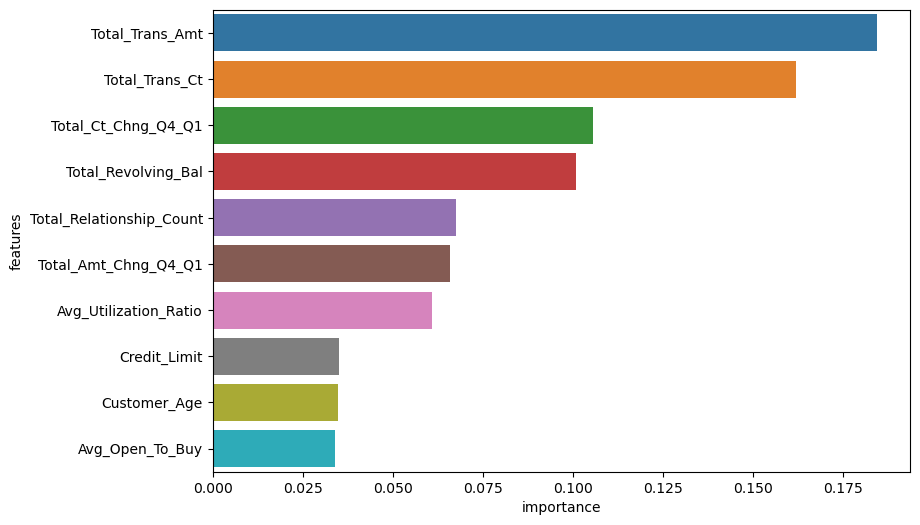

In [122]:
importance = rf_model.feature_importances_
feature_names = df_dummies.drop("churn", axis = 1).columns
feature_importance = pd.DataFrame({"features":feature_names, "importance":importance})
feature_importance = feature_importance.sort_values(by = "importance", ascending = False)
feature_importance

plt.figure(figsize = (9, 6))
sns.barplot(y = "features", x = "importance", data = feature_importance.head(10),
            hue = "features")

In [123]:
important_features = feature_importance["features"].head(14)
important_features

10             Total_Trans_Amt
11              Total_Trans_Ct
12         Total_Ct_Chng_Q4_Q1
7          Total_Revolving_Bal
3     Total_Relationship_Count
9         Total_Amt_Chng_Q4_Q1
13       Avg_Utilization_Ratio
6                 Credit_Limit
0                 Customer_Age
8              Avg_Open_To_Buy
5        Contacts_Count_12_mon
2               Months_on_book
4       Months_Inactive_12_mon
1              Dependent_count
Name: features, dtype: object

**Note:** <br>
We can see that **Total_Trans_Amt**, **Total_Trans_Ct**, and **Avg_Utilization_Ratio** are among the top 10 most important features from the Random Forest model. This observation aligns with our previous findings from the box plots. These three features, along with the other most important features identified by the Random Forest model, are effective in explaining the variability (or impurity) in the data.

This means that these features are critical for predicting the target variable and should be given special consideration in further analysis or model development.

**Note:** <br>
Kmeans clustering would not give us very accurate result if we include the categorical columns as dummy variables. This algorithm is based on measuring the distance of the data points from each other and best result would occur if we only use the numerical variables. <br>
We would use Kmeans clustering only on numerical data and compare our findings with random forest results.

<font size = 5> **KMeans Clustering:** <font>

<font size = 5> Scale Data: <font>

In [141]:
X_num = df.drop(columns=["churn"]).select_dtypes(exclude="object")

X_train_num, X_test_num, Y_train, Y_test = train_test_split(X_num, Y, test_size=0.3, random_state=22)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)


X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

<font size = 5> Find best number of clusters: <font>

In [143]:
# Calculate sample weights based on class imbalance
class_counts = np.bincount(Y_train)
sample_weights = np.where(Y_train == 1, 1, class_counts[1] / class_counts[0])

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, random_state = 20)
    kmeans.fit(X_train_num_scaled,
               sample_weight = sample_weights)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

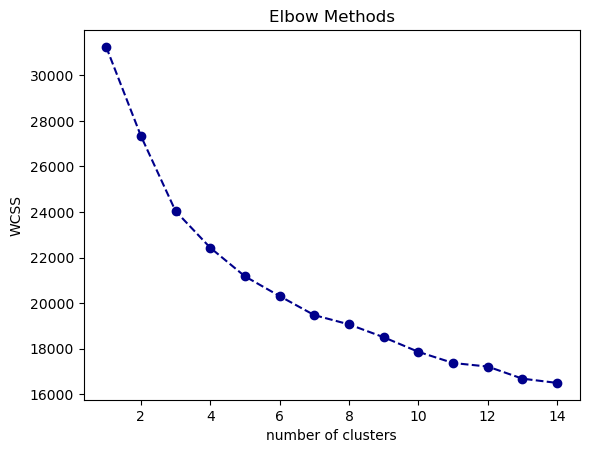

In [144]:
#Find best number of clusters based on elbow method
plt.plot(range(1,15), wcss, linestyle = "--", marker = "o", color = "darkblue")
plt.title("Elbow Methods")
plt.xlabel("number of clusters")
plt.ylabel("WCSS")

We have calculated wcss for different number of clusters(1 to 15) and plotted them above. <br>
Based on the plot, the elbow happens at n_clusters = 4. We will use that in our Kmeans model.

<font size = 5> Fit KMeans: <font>

In [145]:
kmeans = KMeans(n_clusters = 3, random_state = 22)
kmeans.fit(X_train_num_scaled, sample_weight = sample_weights)
df_train_with_cluster = X_train_num_scaled.copy()
df_train_with_cluster["cluster"]= kmeans.labels_
df_train_with_cluster["churn"] = Y_train

In [146]:
test_clusters = kmeans.predict(X_test_num_scaled)
df_test_with_cluster = X_test_num_scaled.copy()
df_test_with_cluster["cluster"] = test_clusters
df_test_with_cluster["churn"] = Y_test

In [154]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(df_train_with_cluster.drop(columns=["churn"]), Y_train)

y_train_pred = lr.predict(df_train_with_cluster.drop(columns=["churn"]))
y_test_pred = lr.predict(df_test_with_cluster.drop(columns=["churn"]))

from sklearn.metrics import accuracy_score, classification_report

train_accuracy = accuracy_score(y_true=Y_train, y_pred=y_train_pred)
test_accuracy = accuracy_score(y_true=Y_test, y_pred=y_test_pred)

print(f"Train Accuracy: {accuracy_score(Y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(Y_test, y_test_pred):.2f}")


print("TRAIN CLASSIFICATION REPORT:")
print(classification_report(Y_train, y_train_pred))

print("TEST CLASSIFICATION REPORT:")
print(classification_report(Y_test, y_test_pred))

Train Accuracy: 0.90
Test Accuracy: 0.89
TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5972
           1       0.76      0.57      0.65      1116

    accuracy                           0.90      7088
   macro avg       0.84      0.77      0.80      7088
weighted avg       0.90      0.90      0.90      7088

TEST CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2528
           1       0.73      0.54      0.62       511

    accuracy                           0.89      3039
   macro avg       0.82      0.75      0.78      3039
weighted avg       0.88      0.89      0.88      3039



<font size = 5> Checking out majority class of each cluster <font>

In [98]:
cm = df_train_with_cluster.loc[:, ["churn", "cluster"]].groupby(["cluster", "churn"]).size().reset_index(name = "count")
cm

,cluster,churn,count
0,0,0.0,762
1,0,1.0,124
2,1,0.0,2239
3,1,1.0,379
4,2,0.0,1234
5,2,1.0,196


Text(0.5, 1.0, 'class majority in each cluster')

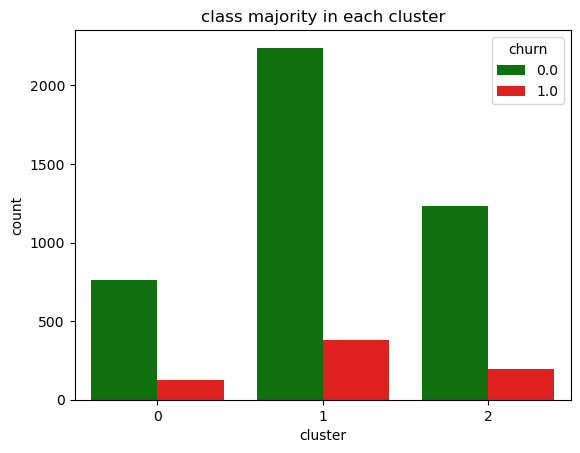

In [99]:
sns.barplot(x = "cluster", y = "count", data = cm, 
            hue = "churn", palette = ["green", "red"])
plt.title("class majority in each cluster")

In [ ]:
from sklearn

<font size = 5> **Model Evaluation:** <font>

In [30]:
# Evaluate the result
Y = df["churn"]
Y_pred = df["churn_predict"]

accuracy = accuracy_score(Y, Y_pred)
matrix = confusion_matrix(Y, Y_pred)

TN, FP, FN, TP = matrix.ravel()

# Compute sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy is ", round(accuracy, 3))
print("Sensitivity is:", round(sensitivity,3))
print("Specificity is:", round(specificity, 3))

Accuracy is  0.97
Sensitivity is: 0.884
Specificity is: 0.987


Text(0.5, 1.0, 'Confusion Matrix')

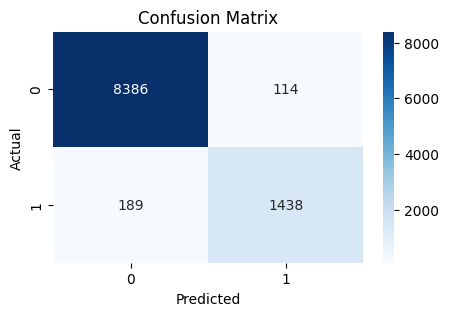

In [31]:
plt.figure(figsize = (5, 3))
sns.heatmap(matrix, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

<font size = 5> **Conclusion:** <font>

We used the Within-Cluster Sum of Squares (WCSS) method to determine the optimal number of clusters for our KMeans model, concluding that n_clusters = 4 is the best choice. The resulting model achieved an **accuracy of 0.97**, with a **sensitivity (predicting churn customers) of 0.88** and a **specificity (predicting non-churn customers) of 0.99**. This indicates that the model effectively clusters customers, accurately identifying both churn and non-churn groups.